<a href="https://colab.research.google.com/github/chany-ahn/otaku-generator/blob/main/otaku_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install DALL-E
!pip install dalle-pytorch --upgrade
!apt install libcairo2-dev
!pip install pycairo
!pip instal pyyaml

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libcairo2-dev is already the newest version (1.15.10-2ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
ERROR: unknown command "instal" - maybe you meant "install"


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import cv2
import torch
from google.colab import drive
import PIL
import io
from tqdm.autonotebook import tqdm, trange
import os

import urllib3
from bs4 import BeautifulSoup as bs
import requests

import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from IPython.display import display, display_markdown

from dall_e import map_pixels, unmap_pixels, load_model

from dalle_pytorch import DiscreteVAE, DALLE

In [ ]:
target_image_size = 256

def png_to_jpg(img_path):
  im1 = PIL.Image.open(img_path)
  rgb_im1 = im1.convert('RGB')
  rgb_im1.save(str(img_path)[:-4] + '.jpg')

def download_image(url):
    return PIL.Image.open(url)

def preprocess(img):
    s = min(img.size)
    
    # if s < target_image_size:
    #     raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    # img = torch.unsqueeze(T.ToTensor()(img), 0)
    return T.ToTensor() (img)

## Text collection for Data



In [ ]:
url = "https://genshin-impact.fandom.com/wiki/Characters"

In [ ]:
# Used to make the request to open page
uClient = urllib3.PoolManager()
# get the informaiton form the page
getPage = uClient.request('GET', url)
# storing the html page source data
pageInfo = getPage.data

# using the beautiful soup object
soup = bs(pageInfo, 'lxml')

In [ ]:
# find all the tables with the given class name
char_tables = soup.find_all("table", attrs={"class": "article-table sortable"})
char_info = char_tables[0]
char_info = char_info.find_all("tr")
char_info = char_info[1:len(char_info)]

In [ ]:
for tr in char_info:
  print(len(tr.find_all('td')))

6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6


In [ ]:
print(char_info[0].find_all('td')[1:6])

[<td><a href="/wiki/Albedo" title="Albedo">Albedo</a>
</td>, <td><img alt="5 Stars" class="lazyload" data-image-key="Icon_5_Stars.png" data-image-name="Icon 5 Stars.png" data-src="https://static.wikia.nocookie.net/gensin-impact/images/2/2b/Icon_5_Stars.png/revision/latest/scale-to-width-down/63?cb=20201226100736" decoding="async" height="16" src="data:image/gif;base64,R0lGODlhAQABAIABAAAAAP///yH5BAEAAAEALAAAAAABAAEAQAICTAEAOw%3D%3D" title="5 Stars" width="63"/>
</td>, <td><span style="white-space:nowrap;"><a href="/wiki/Geo" title="Geo"><img alt="Element Geo.png" class="lazyload" data-image-key="Element_Geo.png" data-image-name="Element Geo.png" data-src="https://static.wikia.nocookie.net/gensin-impact/images/4/4a/Element_Geo.png/revision/latest/scale-to-width-down/20?cb=20201116063036" decoding="async" height="20" src="data:image/gif;base64,R0lGODlhAQABAIABAAAAAP///yH5BAEAAAEALAAAAAABAAEAQAICTAEAOw%3D%3D" width="20"/></a> <a href="/wiki/Geo" title="Geo">Geo</a></span>
</td>, <td><span

In [ ]:
# get text data for each of the characters
text = []
count = 0
for tr in char_info:
  char_tings = tr.find_all('td')[1:6]
  name = char_tings[0].a.text
  if name == "Traveler":
    continue
  rarity = char_tings[1].img.attrs['alt']
  element = char_tings[2].a.attrs['title']
  weapon = char_tings[3].a.attrs['title']
  clan = ''
  if char_tings[4].find('a') == None:
    clan = "nowhere"
  else:
    clan = char_tings[4].a.text
    
  text.append(f"A waifu named {name} with {rarity} {element} {weapon} {clan}")
  
for t in text:
  print(t)

A waifu named Albedo with 5 Stars Geo Sword Mondstadt
A waifu named Aloy with 5 Stars Cryo Bow nowhere
A waifu named Amber with 4 Stars Pyro Bow Mondstadt
A waifu named Arataki Itto with 5 Stars Geo Claymore Inazuma
A waifu named Barbara with 4 Stars Hydro Catalyst Mondstadt
A waifu named Beidou with 4 Stars Electro Claymore Liyue
A waifu named Bennett with 4 Stars Pyro Sword Mondstadt
A waifu named Chongyun with 4 Stars Cryo Claymore Liyue
A waifu named Diluc with 5 Stars Pyro Claymore Mondstadt
A waifu named Diona with 4 Stars Cryo Bow Mondstadt
A waifu named Eula with 5 Stars Cryo Claymore Mondstadt
A waifu named Fischl with 4 Stars Electro Bow Mondstadt
A waifu named Ganyu with 5 Stars Cryo Bow Liyue
A waifu named Gorou with 4 Stars Geo Bow Inazuma
A waifu named Hu Tao with 5 Stars Pyro Polearm Liyue
A waifu named Jean with 5 Stars Anemo Sword Mondstadt
A waifu named Kaedehara Kazuha with 5 Stars Anemo Sword Inazuma
A waifu named Kaeya with 4 Stars Cryo Sword Mondstadt
A waifu name

In [ ]:
# This can be changed to a GPU, e.g. 'cuda:0'.
dev = torch.device('cuda:0')
print(dev)
drive.mount('/content/gdrive')

cuda:0
Mounted at /content/gdrive


## Image processing

In [ ]:
# read in images
from pathlib import Path
otaku_path = Path("/content/gdrive/MyDrive/otaku_database")

In [ ]:
# don't have to run this anymore
for category in ['Portrait', 'Game']:
  for image in otaku_path.glob(f"Otaku_*_{category}.png"):
    png_to_jpg(image)

In [ ]:
# read in images
imgs = [preprocess(download_image(image)) for category in ['Portrait', 'Game'] for image in otaku_path.glob(f"Otaku_*_{category}.jpg")]
len(imgs), imgs[0].shape
imgs[0]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:405: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

(499, 332, 3)

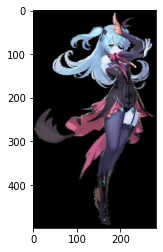

In [ ]:
to_disp = [cv2.imread(str(image)) for category in ['Portrait', 'Game'] for image in otaku_path.glob(f"Otaku_*_{category}.jpg")]
plt.imshow(to_disp[0])
to_disp[1].shape

# DALL-E Model from the paper

In [ ]:
# For faster load times, download these files locally and use the local paths instead.
enc = load_model("https://cdn.openai.com/dall-e/encoder.pkl", dev)
dec = load_model("https://cdn.openai.com/dall-e/decoder.pkl", dev)


In [ ]:
print(dec)

In [ ]:
z_logits = enc(imgs[0])

In [ ]:
z = torch.argmax(z_logits, axis=1)
z = F.one_hot(z, num_classes=enc.vocab_size).permute(0, 3, 1, 2).float()

x_stats = dec(z).float()
x_rec = unmap_pixels(torch.sigmoid(x_stats[:, :3]))
x_rec = T.ToPILImage(mode='RGB')(x_rec[0])

display_markdown('Reconstructed image:')
display(x_rec)

# Separate DALL-E implementation

## Last minute pre-processing

### Captions

In [ ]:
captions = [word.split() for word in text]
captions[1]

['A', 'waifu', 'named', 'Aloy', 'with', '5', 'Stars', 'Cryo', 'Bow', 'nowhere']

In [ ]:
import itertools

all_words = list(sorted(frozenset(list(itertools.chain.from_iterable(captions)))))
word_tokens = dict(zip(all_words, range(1, len(all_words) + 1)))
caption_tokens = [[word_tokens[w] for w in c] for c in captions]
caption_tokens

[[3, 77, 75, 4, 78, 2, 59, 24, 61, 44],
 [3, 77, 75, 5, 78, 2, 59, 17, 13, 76],
 [3, 77, 75, 6, 78, 1, 59, 48, 13, 44],
 [3, 77, 75, 8, 29, 78, 2, 59, 24, 16, 28],
 [3, 77, 75, 10, 78, 1, 59, 27, 14, 44],
 [3, 77, 75, 11, 78, 1, 59, 20, 16, 41],
 [3, 77, 75, 12, 78, 1, 59, 48, 61, 44],
 [3, 77, 75, 15, 78, 1, 59, 17, 16, 41],
 [3, 77, 75, 18, 78, 2, 59, 48, 16, 44],
 [3, 77, 75, 19, 78, 1, 59, 17, 13, 44],
 [3, 77, 75, 21, 78, 2, 59, 17, 16, 44],
 [3, 77, 75, 22, 78, 1, 59, 20, 13, 44],
 [3, 77, 75, 23, 78, 2, 59, 17, 13, 41],
 [3, 77, 75, 25, 78, 1, 59, 24, 13, 28],
 [3, 77, 75, 26, 62, 78, 2, 59, 48, 47, 41],
 [3, 77, 75, 30, 78, 2, 59, 7, 61, 44],
 [3, 77, 75, 32, 35, 78, 2, 59, 7, 61, 28],
 [3, 77, 75, 33, 78, 1, 59, 17, 61, 44],
 [3, 77, 75, 34, 9, 78, 2, 59, 17, 61, 28],
 [3, 77, 75, 36, 78, 2, 59, 20, 61, 41],
 [3, 77, 75, 37, 78, 2, 59, 48, 14, 44],
 [3, 77, 75, 39, 54, 78, 1, 59, 20, 13, 28],
 [3, 77, 75, 40, 78, 1, 59, 20, 14, 44],
 [3, 77, 75, 43, 78, 2, 59, 27, 14, 44],
 [3

In [ ]:
longest_caption = max(len(c) for c in captions)
captions_array = np.zeros((len(caption_tokens), longest_caption), dtype=np.int64)
for i in range(len(caption_tokens)):
    captions_array[i, :len(caption_tokens[i])] = caption_tokens[i]
    
captions_array = torch.from_numpy(captions_array).to(dev)
captions_mask = captions_array != 0
captions_array

tensor([[ 3, 77, 75,  4, 78,  2, 59, 24, 61, 44,  0],
        [ 3, 77, 75,  5, 78,  2, 59, 17, 13, 76,  0],
        [ 3, 77, 75,  6, 78,  1, 59, 48, 13, 44,  0],
        [ 3, 77, 75,  8, 29, 78,  2, 59, 24, 16, 28],
        [ 3, 77, 75, 10, 78,  1, 59, 27, 14, 44,  0],
        [ 3, 77, 75, 11, 78,  1, 59, 20, 16, 41,  0],
        [ 3, 77, 75, 12, 78,  1, 59, 48, 61, 44,  0],
        [ 3, 77, 75, 15, 78,  1, 59, 17, 16, 41,  0],
        [ 3, 77, 75, 18, 78,  2, 59, 48, 16, 44,  0],
        [ 3, 77, 75, 19, 78,  1, 59, 17, 13, 44,  0],
        [ 3, 77, 75, 21, 78,  2, 59, 17, 16, 44,  0],
        [ 3, 77, 75, 22, 78,  1, 59, 20, 13, 44,  0],
        [ 3, 77, 75, 23, 78,  2, 59, 17, 13, 41,  0],
        [ 3, 77, 75, 25, 78,  1, 59, 24, 13, 28,  0],
        [ 3, 77, 75, 26, 62, 78,  2, 59, 48, 47, 41],
        [ 3, 77, 75, 30, 78,  2, 59,  7, 61, 44,  0],
        [ 3, 77, 75, 32, 35, 78,  2, 59,  7, 61, 28],
        [ 3, 77, 75, 33, 78,  1, 59, 17, 61, 44,  0],
        [ 3, 77, 75, 34,  9,

### Photos

In [ ]:
images = torch.stack(imgs).to(dev)

In [ ]:
images.shape

torch.Size([92, 3, 256, 256])

## Training VAE

In [ ]:
def fit(model, opt, criterion, scheduler, train_x, train_y, epochs, batch_size,
        model_file, trainer, n_train_samples=None):
    epoch_loss_train = []

    if n_train_samples is None:
        n_train_samples = train_x.shape[0]

    t = trange(epochs)
    for _ in t:
        rnd_idx = list(range(n_train_samples))
        np.random.shuffle(rnd_idx)
        losses = []
        for batch_idx in range(0, n_train_samples, batch_size):
            model.train()
            opt.zero_grad()
            loss = trainer(model, train_x, train_y, rnd_idx[batch_idx:(batch_idx + batch_size)], criterion)
            loss.backward()
            losses.append(loss.item())
            opt.step()

        epoch_loss_train.append(np.mean(losses))
        scheduler.step()

        t.set_description(f"train: {epoch_loss_train[-1]:.3f}")

    torch.save(model.state_dict(), model_file)
    model.eval()
    return model, epoch_loss_train

In [ ]:
def train_vae_batch(vae, images, _, idx, __):
    loss = vae(images[idx, ...], return_loss = True)
    return loss

In [ ]:
vae = DiscreteVAE(
    image_size = 256,
    num_layers = 3,           # number of downsamples - ex. 256 / (2 ** 3) = (32 x 32 feature map)
    num_tokens = 8192,        # number of visual tokens. in the paper, they used 8192, but could be smaller for downsized projects
    codebook_dim = 512,       # codebook dimension
    hidden_dim = 64,          # hidden dimension
    num_resnet_blocks = 1,    # number of resnet blocks
    temperature = 0.9,        # gumbel softmax temperature, the lower this is, the harder the discretization
    straight_through = False, # straight-through for gumbel softmax. unclear if it is better one way or the other
).to(dev)

opt = torch.optim.Adam(vae.parameters(), lr=0.001, weight_decay=0.0)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, 0.99)

In [ ]:
vae_model_file = "/content/gdrive/MyDrive/otaku_model/otakue_VAE.model"
if not os.path.exists(vae_model_file):
    vae, loss_history = fit(vae, opt, None, scheduler, images, None, 16, 16, vae_model_file, train_vae_batch)
    plt.plot(loss_history)
else:
    vae.load_state_dict(torch.load(vae_model_file))

## Training DALL-E

In [ ]:
with torch.no_grad():
    all_image_codes = vae.get_codebook_indices(images)
    all_images_decoded = vae.decode(all_image_codes)
    
all_image_codes[np.random.choice(images.shape[0], 10), ...]

images.to('cpu')

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0

In [ ]:
def train_dalle_batch(vae, train_data, _, idx, __):
    text, image_codes, mask = train_data
    loss = dalle(text[idx, ...], image_codes[idx, ...], return_loss=True)
    return loss

In [ ]:
dalle = DALLE(
    dim = 1024,
    vae = vae,                  # automatically infer (1) image sequence length and (2) number of image tokens
    num_text_tokens = len(word_tokens) + 1,    # vocab size for text
    text_seq_len = longest_caption,         # text sequence length
    depth = 12,                 # should aim to be 64
    heads = 16,                 # attention heads
    dim_head = 64,              # attention head dimension
    attn_dropout = 0.1,         # attention dropout
    ff_dropout = 0.1            # feedforward dropout
).to(dev)

opt = torch.optim.Adam(dalle.parameters(), lr=0.001, weight_decay=0.0)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, 0.98)

In [ ]:
np.random.seed(1)
train_fraction = 0.3
train_idx = np.random.choice(len(captions), int(len(captions) * train_fraction))


In [ ]:
dalle_model_file = "/content/gdrive/MyDrive/otaku_model/otakue_dalle_model.model"
if not os.path.exists(dalle_model_file):
    dalle, loss_history = fit(dalle, opt, None, scheduler, 
                              (captions_array[train_idx, ...], all_image_codes[train_idx, ...], captions_mask[train_idx, ...]), None, 32, 1, 
                              dalle_model_file, train_dalle_batch, 
                              n_train_samples=len(train_idx))

    plt.plot(loss_history)
else:
    dalle.load_state_dict(torch.load(dalle_model_file))

tensor([[ 3, 77, 75,  4, 78,  2, 59, 24, 61, 44,  0],
        [ 3, 77, 75,  5, 78,  2, 59, 17, 13, 76,  0]], device='cuda:0')

In [ ]:
generated_images = []
with torch.no_grad():
    for i in trange(0, 1, 1):
        generated = dalle.generate_images(captions_array[i:i + 1, ...])
        generated_images.append(generated)


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
generated_images

[tensor([[[[ 0.0396,  0.0403,  0.0405,  ..., -0.1947, -0.1431, -0.0434],
           [ 0.0399,  0.0416,  0.0406,  ..., -0.5291, -0.4766, -0.1974],
           [ 0.0398,  0.0409,  0.0410,  ..., -0.5967, -0.5442, -0.2206],
           ...,
           [-0.2673, -0.5694, -0.6413,  ..., -0.6100, -0.5761, -0.2094],
           [-0.2468, -0.5434, -0.5909,  ..., -0.5986, -0.5243, -0.2003],
           [-0.0635, -0.1832, -0.2106,  ..., -0.1794, -0.1881, -0.0578]],
 
          [[ 0.0321,  0.0349,  0.0331,  ..., -0.2034, -0.1650, -0.0519],
           [ 0.0347,  0.0350,  0.0348,  ..., -0.5899, -0.4927, -0.2191],
           [ 0.0331,  0.0365,  0.0345,  ..., -0.6297, -0.5529, -0.2343],
           ...,
           [-0.3402, -0.5860, -0.7048,  ..., -0.6176, -0.6115, -0.2353],
           [-0.2527, -0.5704, -0.6087,  ..., -0.5998, -0.5693, -0.2321],
           [-0.1049, -0.1916, -0.2558,  ..., -0.2088, -0.2226, -0.0681]],
 
          [[-0.0915, -0.0869, -0.0881,  ..., -0.2527, -0.2614, -0.1562],
           [-

In [ ]:
generated_images = generated_images.cpu().numpy()

AttributeError: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


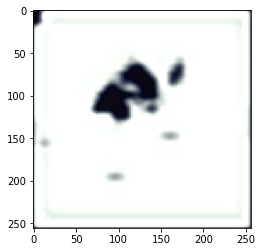

In [ ]:
plt.imshow(np.swapaxes(np.abs(generated_images[0]),0,2))